# Fokker-Planck - VarQITE $\chi_0=10^{-3}$

Steps:
- Classical PDE solver (benchmark)
- Initial distribution function
    - fit a target distribution with the correct sigma0
    - get advection parameter to get correct initial function
- VarQITE MVP for digital quantum circuit approach

Ansatz: n=6 (#qubits) and k=5 (#layers)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import PDEsolverQRR
from PDEsolverQRR import *
import pandas as pd
import pickle
from numpy import exp, sqrt, pi, log
#from scipy.linalg import solve
#from scipy.linalg import cho_factor, cho_solve

from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit, transpile #, execute
from qiskit.circuit.library import RZGate
from qiskit_aer import Aer  # Correct import for Aer
#from scipy.linalg import expm
from scipy.sparse.linalg import expm_multiply

this_files_name = 'VarQITE_chi3'

In [2]:
# load results
infile = open(this_files_name+"_params0_n6k5",'rb')
nqubits, klayers, chi0, nparams, steps0, f0_target, f0_target_centered, params_new0, g0, sigma0, cost0lst, gmlst = pickle.load(infile)
params_new0 = np.array(params_new0)

ell = 1/(2**nqubits+1)
Id = np.eye(2**nqubits)
def f(i):
    return np.roll(Id,i,axis=0)
#Hdrift = -(f(1)-f(-1))/(2*ell) # order 1
Hdrift = -(1*f(-2)-8*f(-1)+8*f(+1)-1*f(+2))/(12*ell) # order 2

In [3]:
params_new0

array([0.56101488, 4.18524893, 1.56227887, 2.99988518, 4.60022372,
       1.58026792, 4.78002955, 6.27244868, 1.56052582, 4.70345939,
       3.14054966, 3.2412671 , 4.30641904, 1.57128597, 1.56948526,
       2.43439885, 3.70430066, 0.21031043, 3.13869724, 2.38024259,
       4.71327119, 3.14196561, 3.18690605, 4.71063997, 0.02521196,
       0.1       , 1.        ])

In [4]:
# parameters
tdim = 400 #300 is the minimum for the PDE
tmax = 20.0
tlst_vqs = np.linspace(0,tmax,tdim)

print("#params=",nparams, ", 2^n=", 2**nqubits)

#params= 27 , 2^n= 64


In [6]:
# time resolution
dt = tmax/tdim

# L matrix
Lmatrix = getL(B=2.5e3 * chi0/(1e-3), tmax=tmax, tdim=tdim, gmlst=gmlst, g0=g0)
Lmatrix[0,:] = 0
Lmatrix[-1,:] = 0

# initial target distribution
f0 = np.zeros(2**nqubits)
f0 = exp( -0.5*((gmlst-g0)/(sigma0) )**2 ) # * np.heaviside(1800-gmlst,0) # 1*dx*g0
f0[0] = 0
f0[-1] = 0
f0_target = f0/sqrt(np.sum(np.abs(f0)**2))
#
f0_target_centered = exp( -0.5*((gmlst-np.mean(gmlst))/(sigma0) )**2 )
f0_target_centered = f0_target_centered/sqrt(np.sum(np.abs(f0_target_centered)**2))

100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 21.57it/s]


100%|██████████████████████████████████████| 400/400 [00:00<00:00, 93305.24it/s]


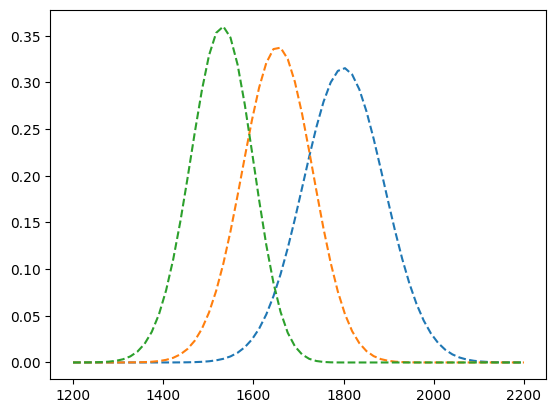

In [7]:
# PDE-solver
fPDElst = np.zeros((tdim,2**nqubits))
fPDE = np.real( np.copy( f0_target ) )
#fPDE = np.real( np.copy( getPsi(thetalst[0,:]) ) )
fPDE /= np.trapz(fPDE)
for i in trange(tdim):
    fPDElst[i,:] = fPDE
    fPDE += dt * (np.real(Lmatrix) @ fPDE)
    
# check convergence of PDE solver. if it doesn't converge, then VarQITE will for sure not converge either
yth = fPDElst[0,:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot( gmlst, yth, '--', color='tab:blue' )
yth = fPDElst[int(tdim/2),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot( gmlst, yth, '--', color='tab:orange' )
yth = fPDElst[int(tdim*0.99999),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot( gmlst, yth, '--', color='tab:green' )
plt.show()

In [3]:
def getQiskitU(x):
    psi0 = np.zeros(2**nqubits); psi0[0] = 1
    qc = QuantumCircuit(nqubits)
    # first RY rotations
    for i in range(nqubits):
        if i==nqubits-1:
            qc.ry(pi/2, i) # this parameter is fixed
        else:
            qc.ry(x[i], i) # parameters that can be optimized
    # intermediate blocks 
    for k in range(klayers-1):
        for i in range(nqubits-1):
            qc.cx( (i)%(nqubits-1) , (i+1)%(nqubits-1) )
        for i in range(nqubits-1):
            qc.ry(x[ i + (k+1)*(nqubits-1) ], i) # parameters that can be optimized
    # final symmetry enforcing block
    for i in range(nqubits-1):
        qc.cx(nqubits-1, nqubits-i-2)
    qc = qc.reverse_bits()
    Uqiskit = Operator(qc).data
    return np.real( Uqiskit @ psi0)
    
def getPsi(x):
    return x[-1] * expm_multiply( -Hdrift * x[-2], getQiskitU(x[:-2]) ) #get_UFD(nqubits, ) @  #get_UFD

def getPsiGrad(x, i, dx=5e-7):
    if i==nparams-1:
        return expm_multiply( -Hdrift*x[-2], getQiskitU(x[:-2]) )
    elif i==nparams-2:
        return -Hdrift @ getPsi(x)
    else:
        xpp = np.copy(x); xpp[i] = (xpp[i]+dx)%(2*pi)
        xmm = np.copy(x); xmm[i] = (xmm[i]-dx)%(2*pi)
        dpsi = (getQiskitU(xpp) - getQiskitU(xmm))/(2*dx)
        return x[-1] * expm_multiply( -Hdrift * x[-2], dpsi )
        
def get_dthetadt(theta, Lmatrix):
    Mkj = np.zeros((nparams, nparams))
    Vk = np.zeros(nparams)
    psi = np.real( getPsi(theta) )
    #
    psiks = np.zeros( (nparams,2**nqubits) )
    for k in range(nparams):
        psiks[k,:] = getPsiGrad(theta,k)
    for k in range(nparams):
        psik = np.copy(psiks[k,:])
        Vk[k] = np.dot( psik, Lmatrix @ psi )
        for j in range(k,nparams):
            psij = np.copy(psiks[j,:])
            Mkj[k,j] = np.dot( psik, psij )
            Mkj[j,k] = Mkj[k,j]
    #return np.linalg.solve(Mkj, Vk)
    return np.linalg.lstsq(Mkj, Vk)[0]

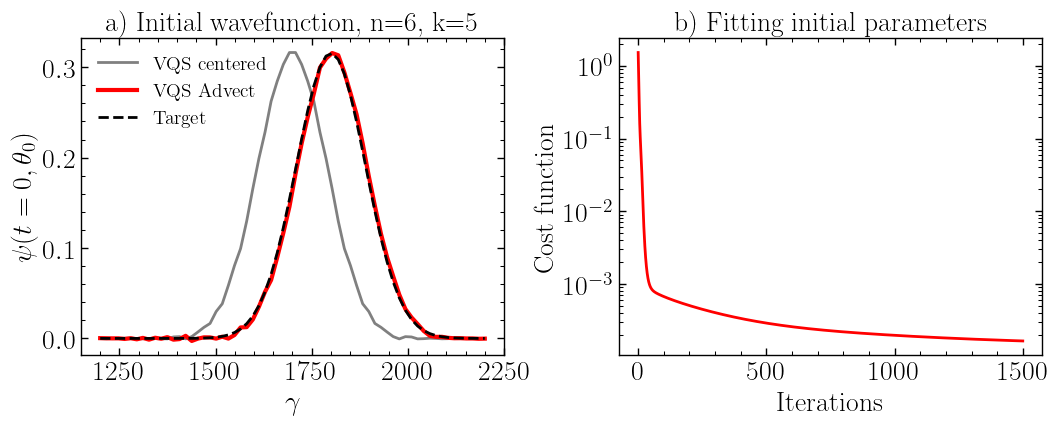

In [10]:
#fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

# centered
params_new0[-2] = 0
yth = np.real( getPsi(params_new0) ); yth /= np.sign(np.trapz(yth))
axes[0].plot( gmlst, yth , label='VQS centered', color='grey' )
# correct for initial average energy
params_new0[-2] = (g0-np.mean(gmlst))/(np.max(gmlst)-np.min(gmlst))
yth = np.real( getPsi(params_new0) ); yth /= np.sign(np.trapz(yth))
axes[0].plot( gmlst, yth , label='VQS Advect', color='r', linewidth=3 )
axes[0].plot( gmlst, f0_target , 'k--', label=r'Target')
axes[0].set_title( 'a) Initial wavefunction, n={}, k={}'.format(nqubits, klayers))
axes[1].set_title( 'b) Fitting initial parameters' )

axes[1].plot(cost0lst, 'r-')
axes[1].set_yscale('log')



axes[0].legend(fontsize=14, frameon=False)
axes[0].set_xlabel(r'$\gamma$')
axes[0].set_ylabel(r'$\psi(t=0,\theta_0)$')
axes[1].set_xlabel(r'Iterations')
axes[1].set_ylabel(r'Cost function')
asp = 3/4
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[0].set_aspect(aspect=asp/axesratio)
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
axes[1].set_aspect(aspect=asp/axesratio)

plt.tight_layout()
#plt.savefig('FokkerPlanck_VarQITE_chi3_psi0_cost.pdf',transparent=True)
plt.show()

In [10]:
# MVP
theta = np.copy(params_new0)
thetalst = np.zeros((tdim,len(params_new0)))
for i in trange(tdim):
    thetalst[i,:] = theta
    theta = theta + get_dthetadt(theta, Lmatrix) * dt
    theta[:-2] = theta[:-2] % (2*pi)

100%|█████████████████████████████████████████| 400/400 [02:20<00:00,  2.85it/s]


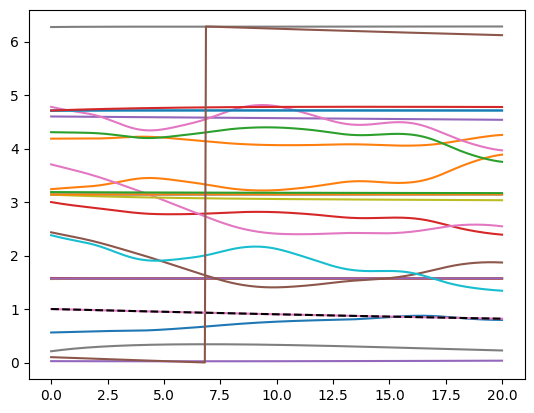

In [11]:
# showing the evolution of variational parameters
plt.plot(tlst_vqs, thetalst % (2*pi) )
plt.plot(tlst_vqs, thetalst[:,-1]  % (2*pi), 'k--')
#plt.xlim([0,0.1])
#plt.ylim([0,10])
plt.show()

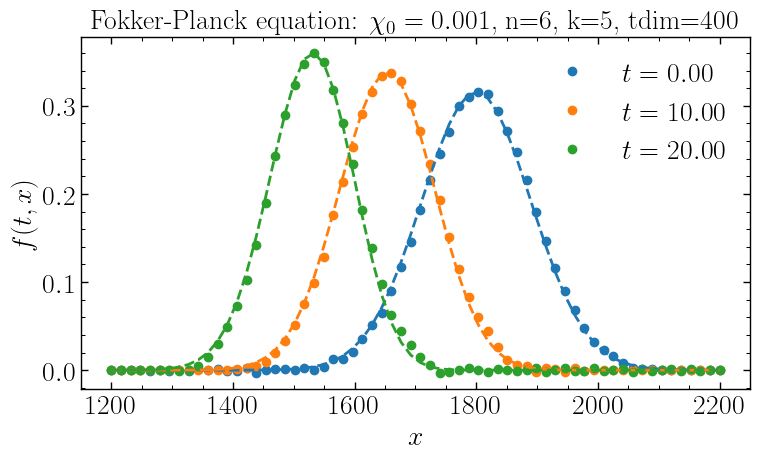

In [8]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

t = tmax*0.0; i = int(t/tmax * tdim);
yth = np.real( getPsi(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, 'o', label=r'$t={:.2f}$'.format(t), color='tab:blue' )
fsnap1 = yth
t = tmax*0.5; i = int(t/tmax * tdim);
yth = np.real( getPsi(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, 'o', label=r'$t={:.2f}$'.format(t), color='tab:orange' )
fsnap2 = yth
t = tmax*0.9999; i = int(t/tmax * tdim);
yth = np.real( getPsi(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, 'o', label=r'$t={:.2f}$'.format(t), color='tab:green' )
fsnap3 = yth


yth = fPDElst[0,:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, '--', color='tab:blue' )
yth = fPDElst[int(tdim/2),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, '--', color='tab:orange' )
yth = fPDElst[int(tdim*0.99999),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
plt.plot(gmlst, yth, '--', color='tab:green' )

# PDE vs VarQITE
#plt.plot(gmlst, yth-100, 'k--', label='PDE' )
#plt.plot(gmlst, yth-100, 'ko', label='VarQITE' )

plt.xlabel(r'$x$')
plt.ylabel(r'$f(t,x)$')
plt.legend(frameon=False)
#plt.ylim([0, 0.8])
plt.title(r'Fokker-Planck equation: ' +r"$\chi_0={}$".format(chi0) +', n={}, k={}, tdim={}'.format(nqubits, klayers,tdim))
plt.tight_layout()
plt.show()

In [14]:
# compute moments from VarQITE
mom1lst = np.zeros(tdim)
mom2lst = np.zeros(tdim)
for i in range(tdim):
    # psi
    yth = np.real( getPsi(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
    mom1lst[i] = np.sum( gmlst * np.abs(yth)**2 )
    mom2lst[i] = np.sqrt( np.sum( (gmlst-mom1lst[i])**2 * np.abs(yth)**2 ) / np.sum( np.abs(yth)**2 ) ) * sqrt(2)

In [9]:
# save results
outfile = open(this_files_name,'wb')
pickle.dump([nqubits, klayers, chi0, tdim, tmax, gmlst, nparams, steps0, f0_target, f0_target_centered, fPDElst, thetalst, mom1lst, mom2lst, tlst_vqs, fsnap1,fsnap2,fsnap3],outfile)
outfile.close()

In [10]:
# load results
infile = open(this_files_name,'rb')
nqubits, klayers, chi0, tdim, tmax, gmlst, nparams, steps0, f0_target, f0_target_centered, fPDElst, thetalst, mom1lst, mom2lst, tlst_vqs, fsnap1,fsnap2,fsnap3 = pickle.load(infile)